#Adversarial Attacks on Deep Neural Networks

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

##Dataset

In [2]:
# load dataset
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

11490434/11490434 [==============================] - 0s 0us/step


##baseline DNN

In [3]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(300, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10)
])
# loss function
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

In [4]:
# train the model
model.fit(x_train, y_train, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 28s 13ms/step - loss: 0.2440 - accuracy: 0.9281
Epoch 2/5
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1095 - accuracy: 0.9661
Epoch 3/5
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0799 - accuracy: 0.9760
Epoch 4/5
1875/1875 [==============================] - 8s 5ms/step - loss: 0.0629 - accuracy: 0.9791
Epoch 5/5
1875/1875 [==============================] - 8s 5ms/step - loss: 0.0497 - accuracy: 0.9841


In [5]:
# evaluate the model
acc = model.evaluate(x_test,  y_test, verbose=2)
acc1 = acc[1]

313/313 - 1s - loss: 0.0698 - accuracy: 0.9790 - 1s/epoch - 3ms/step


## FGSM based untargeted attacks

In [6]:
# x* = x + ε sign(grad(loss(x,y)))
# compute data gradient sign
def sign_grad(x_test, y_test):
  x_tensor = tf.convert_to_tensor(x_test, dtype=tf.float32)
  with tf.GradientTape() as grad:
    grad.watch(x_tensor)
    predict = model(x_tensor)
    loss = loss_fn(y_test, predict)
  gradient = grad.gradient(loss, x_tensor)
  sign_grad = tf.sign(gradient)
  sign_grad = sign_grad.numpy()
  return sign_grad

In [7]:
# perturb
def perturb_untarget(x_test, y_test, epsilon):
  x_perturb = np.clip(x_test + epsilon * sign_grad(x_test, y_test), 0, 1)
  return x_perturb

In [8]:
#the fraction of test images that were correctly classified by the baseline DNN that are mis-classified after adversarial perturbation for each ε
para = [25, 50, 75, 125]
for i in range(len(para)):
  x_perturb = perturb_untarget(x_test, y_test, para[i]/255)
  result = model.evaluate(x_perturb,  y_test, verbose=2)
  rate = (1 - result[1])/acc1
  print("when parameter is " + str(para[i]/255) + ", the success rate of attack is" + str(rate))

313/313 - 1s - loss: 3.9308 - accuracy: 0.2336 - 763ms/epoch - 2ms/step
when parameter is 0.09803921568627451, the success rate of attack is0.7828396487672918
313/313 - 1s - loss: 10.4490 - accuracy: 0.0265 - 742ms/epoch - 2ms/step
when parameter is 0.19607843137254902, the success rate of attack is0.994382050882642
313/313 - 1s - loss: 17.1636 - accuracy: 0.0041 - 731ms/epoch - 2ms/step
when parameter is 0.29411764705882354, the success rate of attack is1.0172625414850471
313/313 - 1s - loss: 32.4931 - accuracy: 1.0000e-04 - 767ms/epoch - 2ms/step
when parameter is 0.49019607843137253, the success rate of attack is1.0213483434622095


## FGSM based targeted attacks

In [9]:
# x* = x - ε sign(grad(loss(x,y')))

In [10]:
def perturb_target(x_test, y_test, epsilon):
  y = []
  for i in range(len(y_test)):
    y.append((y_test[i]+1)%10)
  y = np.array(y)
  x_perturb = np.clip(x_test - epsilon * sign_grad(x_test, y), 0, 1)
  # plt.imshow(x_perturb[0])
  # plt.show()
  return x_perturb

In [11]:
for i in range(len(para)):
  x_perturb = perturb_target(x_test, y_test, para[i]/255)
  result = model.evaluate(x_perturb,  y_test, verbose=2)
  rate = (1 - result[1])/acc1
  print("when parameter is " + str(para[i]/255) + ", the success rate of attack is" + str(rate))

313/313 - 1s - loss: 2.2850 - accuracy: 0.4493 - 872ms/epoch - 3ms/step
when parameter is 0.09803921568627451, the success rate of attack is0.5625127930810391
313/313 - 1s - loss: 7.6169 - accuracy: 0.0709 - 845ms/epoch - 3ms/step
when parameter is 0.19607843137254902, the success rate of attack is0.9490296482278668
313/313 - 1s - loss: 13.2492 - accuracy: 0.0079 - 788ms/epoch - 3ms/step
when parameter is 0.29411764705882354, the success rate of attack is1.0133810300389152
313/313 - 1s - loss: 26.4355 - accuracy: 1.0000e-04 - 780ms/epoch - 2ms/step
when parameter is 0.49019607843137253, the success rate of attack is1.0213483434622095


## Adversarial Retraining against Untargeted FGSM Attacks

In [12]:
parameter = 125/255
x_perturb = perturb_untarget(x_train, y_train, parameter)
x_train_new = np.concatenate([x_train, x_perturb])
y_train_new = np.concatenate([y_train, y_train])

In [13]:
# retrain the adversarially retrained DNN
model.fit(x_train_new, y_train_new, epochs=5)

Epoch 1/5
3750/3750 [==============================] - 17s 5ms/step - loss: 0.2215 - accuracy: 0.9290
Epoch 2/5
3750/3750 [==============================] - 19s 5ms/step - loss: 0.0457 - accuracy: 0.9857
Epoch 3/5
3750/3750 [==============================] - 21s 6ms/step - loss: 0.0342 - accuracy: 0.9889
Epoch 4/5
3750/3750 [==============================] - 17s 5ms/step - loss: 0.0284 - accuracy: 0.9908
Epoch 5/5
3750/3750 [==============================] - 18s 5ms/step - loss: 0.0243 - accuracy: 0.9925


### Report the classification accuracy of the adversarially retrained DNN on the original test dataset that contains only clean inputs.

In [14]:
#  Report the classification accuracy of the adversarially retrained DNN on the original test dataset that contains only clean inputs.
acc = model.evaluate(x_test, y_test, verbose=2)
acc = acc[1]
print("the classification accuracy is" +" "+ str(acc))


313/313 - 1s - loss: 0.0752 - accuracy: 0.9805 - 742ms/epoch - 2ms/step
the classification accuracy is 0.9804999828338623


###  Is the adversarially retrained DNN robust against adversarial perturbations?

In [15]:
for i in range(len(para)):
  x_perturb = perturb_untarget(x_test, y_test, para[i]/255)
  result = model.evaluate(x_perturb,  y_test, verbose=2)
  rate = (1 - result[1])/acc
  print("when parameter is " + str(para[i]/255) + ", the success rate of attack is" + str(rate))

313/313 - 1s - loss: 1.9064 - accuracy: 0.4034 - 742ms/epoch - 2ms/step
when parameter is 0.09803921568627451, the success rate of attack is0.6084650755073234
313/313 - 1s - loss: 3.0160 - accuracy: 0.2851 - 726ms/epoch - 2ms/step
when parameter is 0.19607843137254902, the success rate of attack is0.7291177965308333
313/313 - 1s - loss: 4.2382 - accuracy: 0.2794 - 732ms/epoch - 2ms/step
when parameter is 0.29411764705882354, the success rate of attack is0.7349311795823237
313/313 - 1s - loss: 8.6413 - accuracy: 0.2444 - 714ms/epoch - 2ms/step
when parameter is 0.49019607843137253, the success rate of attack is0.7706272499917933


Comparing the attack's success rate of adversarially retrained DNN model with the basline DNN model, the adversarially retrained DNN do robust against adversarial perturbations

## challenge

In [16]:
def IFGSM_untarget(x_test, y_test, epsilon):
  x_n = x_test
  a = 1
  for i in range(min(epsilon +4, 1.25*epsilon)):
    x_n = perturb_untarget(x_n, y_test, 1/255)
  return x_n
  


In [17]:
new_img = IFGSM_untarget(x_test, y_test, 125)

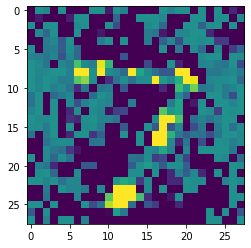

In [18]:
plt.imshow(new_img[0])

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [20]:
SAVE_PATH = "/content/drive/MyDrive/nyu_course/ml_cyber/lab1_img/"

(28, 28)
(28, 28, 3)
(28, 28)


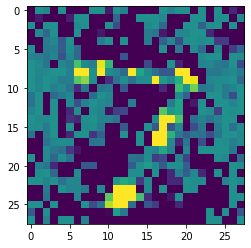

In [21]:
import cv2
print(new_img[0].shape)
# print(new_img[0]*255)
img = cv2.cvtColor((new_img[0]*255).astype('float32'), cv2.COLOR_GRAY2BGR)
print(img.shape)
plt.imshow(img)
imgs = img[:,:,0]
print(imgs.shape)
plt.imshow(imgs)

In [22]:
from PIL import Image
import csv
for i in range(len(new_img)):
  img = cv2.cvtColor((new_img[i]*255).astype('float32'), cv2.COLOR_GRAY2BGR)
  Image.fromarray(img.astype(np.uint8)).save(SAVE_PATH + str(i) + ".png" )
with open(SAVE_PATH + "{images}.csv", "w") as csvfile:
  writer = csv.writer(
      csvfile, delimiter=" ", quotechar="|", quoting=csv.QUOTE_MINIMAL
  )
  for i in range(len(new_img)):
      writer.writerow(str(y_test[i]))